In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine # to run Cheng's code
import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
import assessment.assess_simgraph_07_nn_lgrg as asg
import assessment.compare_with_benchmark as bn

In [2]:
# import importlib
# importlib.reload(asg)

# Load and group neuron spike data

In [3]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

# Check the dataset

In [17]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::16]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [18]:
train_num = 10
val_num = 5

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1342)

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  mnist-sift
train_num =  10 , val_num =  5
number of features:  16
training data contains 5 points (50.00%) of label 1.
validation data contains 2 points (40.00%) of label 1.
train_smpls =  [13088  5221  3066  9069  2026  6787 11998  6782  4016 10360] 
val_smpls =  [13095  5224  9148  3059  7592]
train_lbls =  [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.] 
val_lbls =  [ 1.  1. -1. -1. -1.]
train_des =  [[-0.05136574 -0.0686487   0.00784782 -0.0804113   0.09314343 -0.02251315
   0.10702582  0.00040889 -0.04412514 -0.05261263 -0.07882236  0.13128085
  -0.10208812  0.13569601 -0.04862569  0.15652375]
 [ 0.01214494  0.0596107   0.03856298  0.01258455 -0.0583704  -0.09759864
  -0.07451023 -0.09730593 -0.0377166   0.08250762 -0.01458592  0.01489668
  -0.0553671  -0.08471367 -0.05781839 -0.06755133]
 [-0.06074166 -0.08117931 -0.01991722 -0.08254311  0.05520969  0.04015224
   0.10874702  0.05102118  0.17404433 -0.02957835  0.06388069 -0.00377339
  -0.00667763 -0.10590662 -0.06735576 -0

# Assess the model's performance with random tests

In [19]:
# graph construction and penalty term parameters
nn_params = {'num_hidden_layers':5, 'num_hidden_units':20, 'num_outs':2, \
             'act_func':bn.relu, 'out_func':bn.softmax, 'loss_func':bn.crossent }
# gradient descent parameters
nn_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':1000, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

# randomization parameters
rnd_params = {'train_sizes': [50, 100, 150, 200], 'val_sizes': [100], 'train_its': 3, 'val_its': 10, 'seed': None}

# parameters to visualize the optimized M
fig_params = {}

# path to save the results
res_path_nn = '../../data/experiments/comparison/temp/nn/'
res_path_lgrg = '../../data/experiments/comparison/temp/lgrg/'

In [21]:
val_num_res_sg, val_num_err_sg, val_num_res_lgrg, val_num_err_lgrg = asg.assess_models(data_params, nn_params, nn_opt_params, rnd_params, fig_params, res_path_nn, res_path_lgrg)

   0: eps = 1.00e+00;  train loss (E) =  0.69
  10: eps = 4.00e+00;  train loss (E) =  0.69
  20: eps = 4.00e+00;  train loss (E) =  0.69
  30: eps = 2.00e+00;  train loss (E) =  0.69
  40: eps = 4.00e+00;  train loss (E) =  0.69
  50: eps = 4.00e+00;  train loss (E) =  0.69
  60: eps = 8.00e+00;  train loss (E) =  0.69
  70: eps = 4.00e+00;  train loss (E) =  0.69
  80: eps = 4.00e+00;  train loss (E) =  0.69
  90: eps = 2.00e+00;  train loss (E) =  0.69
 100: eps = 1.00e+00;  train loss (E) =  0.69
 110: eps = 1.00e+00;  train loss (E) =  0.68
 120: eps = 2.50e-01;  train loss (E) =  0.66
 130: eps = 1.25e-01;  train loss (E) =  0.65
 140: eps = 1.25e-01;  train loss (E) =  0.64
 150: eps = 6.25e-02;  train loss (E) =  0.62
 160: eps = 1.25e-01;  train loss (E) =  0.61
 170: eps = 6.25e-02;  train loss (E) =  0.59
 180: eps = 6.25e-02;  train loss (E) =  0.57
 190: eps = 1.25e-01;  train loss (E) =  0.56
 200: eps = 3.12e-02;  train loss (E) =  0.54
 210: eps = 3.12e-02;  train loss 

In [22]:
asg.plot_curves(rnd_params, nn_params, nn_opt_params, data_params['feature_id'], res_path_nn)

In [23]:
asg.plot_curves_without_runtime(rnd_params, nn_params, nn_opt_params, data_params['feature_id'], res_path_lgrg)

# Plot similarity graph and logistic regression validation accuracies together

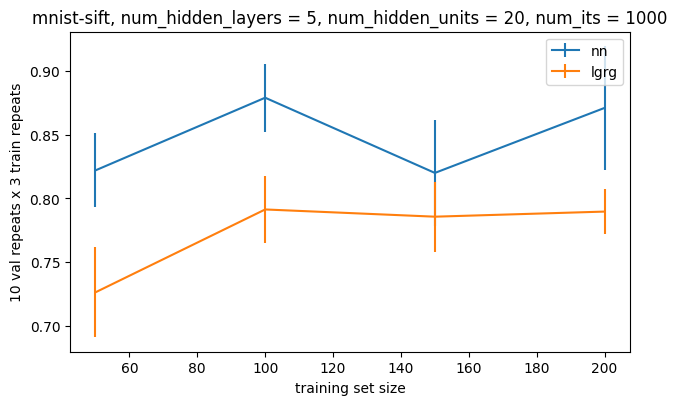

In [27]:
# unpack params
train_sizes = rnd_params['train_sizes']
val_sizes = rnd_params['val_sizes']
train_its = rnd_params['train_its']
val_its = rnd_params['val_its']
assess_qs = ['min_acc', 'val_acc', 'missed', 'false_alarm']

# read sg training curves
curves_sg = {}
errors_sg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_nn+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_sg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_sg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_sg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_sg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2
        
# read lgrg training curves
curves_lgrg = {}
errors_lgrg = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path_lgrg+'curves/train_'+str(i)+'.txt')
    j = 0
    for quantity in assess_qs:
        if i==0:
            curves_lgrg[quantity] = curves_i[j::8].reshape((1, -1))
            errors_lgrg[quantity] = curves_i[j+1::8].reshape((1, -1))
        else:
            curves_lgrg[quantity] = np.concatenate((curves[quantity], [curves_i[j::8]]), axis=0)
            errors_lgrg[quantity] = np.concatenate((errors[quantity], [curves_i[j+1::8]]), axis=0)
        j += 2

# plot training curves
plt.figure(figsize=(7,4))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    plt.errorbar(train_sizes, curves_sg['val_acc'][i], errors_sg['val_acc'][i])
    plt.errorbar(train_sizes, curves_lgrg['val_acc'][i], errors_lgrg['val_acc'][i])
    plt.legend(['nn', 'lgrg'])
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_its, train_its))
    _ = plt.title('{}, num_hidden_layers = {}, num_hidden_units = {}, num_its = {}'.format(data_params['feature_id'], nn_params['num_hidden_layers'], nn_params['num_hidden_units'], nn_opt_params['num_its']))
plt.savefig(res_path_nn+'val_acc_compare.png')